# Homework 5

### Overview
This homework assignment is divided into two parts: 1) Prediction of HOLC labels and 2) geodemographic clustering 

### Deliverables: 
1. Pandas notebook with outputs

In [1]:
# We are going to start importing the libraries we need
# all in one cell. 

# It is a good practice to keep all the imports in one cell so that
# we can easily see what libraries we are using in the notebook.
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

## There is no need to import libraries more than once!

c:\Users\desai\miniforge3\envs\crp4680\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# 1. Predicting HOLC grades
In this exercise, you are going to explore some historical Census data and understand its relationships with the Home Owners' Loan Corporation (HOLC) risk maps. These maps were made by the HOLC in the late 1930s-early 1940s for the HOLC to make assessments of neighborhood risk after the HOLC bailed out underwater borrowers who were unable to pay their mortgage loans as a consequence of the Great Depression. Mortgage risk was assessed with all residential neighborhoods being given an A, B, C, or D grade: 

- A = "best"
- B = "still desirable"
- C = "definitely declining"
- D = "hazardous"

While these maps have become known as the "redlining maps" note that the agency didn't use these maps to make decisions on who/where should get loans. They actually made these maps after loan activities were already over! However, these maps do provide an interesting window into how the real estate industry viewed different neighborhoods, during a period when redlining (by savings and loan banks, the Federal Housing Administration, amongst others) occurred. In 1968, Congress signed the Fair Housing Act of 1968, also known as Title VIII of the Civil Rights Act of 1968, that formally made discrimination by race, sex, color, religion, disability, family status, and national origin illegal. This is considered by many scholars to be the legal end of discriminatory redlining practices (although they still occur, in various ways, to today). 

There are three time periods to consider when we're thinking about the "impacts" of the redlining: 
- The pre-redlining period: for now, we'll say that is 1930 and any 1930-1940 trends. 
- The redlining period: 1940 - 1970
- The post-redlining period: 1980 - present

The overall aim of this study is to understand whether we think there is a relationship between HOLC grades and present-day outcomes in racial outcomes and neighborhood outcomes such as education or median income. The underlying mechanism here might be that HOLC grades led to disinvestment in neighborhoods, which leads to poor conditions, the concentration of poverty, and low opportunities for people who live in that neighborhood. This leads us to test two scenarios: 

1. Can we use neighborhood conditions to predict historical HOLC grades during the period of redlining? 
2. Similarly, if we think that grades were also determined by neighborhood socioeconomic and demographic conditions, can we use these to predict HOLC grades? 

## 1.1 Load in the data
The folder `holc_data` can be downloaded [here](https://www.dropbox.com/scl/fo/efovuq4dg9mmrwhtnvak6/AHew7g8n0jqkuxPGpU3lZBQ?rlkey=g7371rzvg8m2duq86hg3jc6nk&dl=0).

In [5]:
### This is a version of the data with all the years as separate columns
holc_data = gpd.read_file('https://www.dropbox.com/scl/fi/i017f3g4juwtf6rmpijcq/holc_data_1930_2016.geojson?rlkey=scxpkogx5hcj1r1rvdwg297g8&dl=1',driver='GeoJSON')

### This is a version of the data with the years concatenated
holc_data_v2 = []
for y in ['1930','1940','1950','1960','1970','1980','1990','2010', '2016']: 
    df = gpd.read_file(f'holc_data/holc_overlay_{y}')
    df['year'] = y
    holc_data_v2.append(df)

holc_data_v2= pd.concat(holc_data_v2)[['city','holc_grade','population','white_perc','colored_pe','hispanic_p','other_perc','college_pe','median_inc','unemployed','geometry','year']]

holc_data_v2 = holc_data_v2.rename(columns={'colored_pe':'black_perc','hispanic_p':'hispanic_perc','college_pe':'college_perc','unemployed':'unemployed_perc'})

In [14]:
holc_data.columns

Index(['city', 'holc_grade', 'holc_id', 'population_2016', 'white_perc_2016',
       'black_perc_2016', 'hispanic_perc_2016', 'other_perc_2016',
       'college_perc_2016', 'median_inc_2016', 'unemployed_perc_2016',
       'population_1930', 'white_perc_1930', 'black_perc_1930',
       'population_1940', 'white_perc_1940', 'black_perc_1940',
       'population_1950', 'white_perc_1950', 'black_perc_1950',
       'other_perc_1950', 'college_perc_1950', 'median_inc_1950',
       'population_1960', 'white_perc_1960', 'hispanic_perc_1960',
       'black_perc_1960', 'other_perc_1960', 'college_perc_1960',
       'median_inc_1960', 'population_1970', 'white_perc_1970',
       'hispanic_perc_1970', 'black_perc_1970', 'other_perc_1970',
       'college_perc_1970', 'median_inc_1970', 'population_1980',
       'white_perc_1980', 'black_perc_1980', 'hispanic_perc_1980',
       'other_perc_1980', 'college_perc_1980', 'median_inc_1980',
       'unemployed_perc_1980', 'population_1990', 'white_perc_1

In [37]:
pd.set_option('display.max_rows', None)

print(holc_data.city)

pd.reset_option('display.max_rows')

0                                  Akron
1                                 Albany
2                                Altoona
3                               Bay City
4                              Cambridge
5                             Bergen Co.
6                            Springfield
7                             Bergen Co.
8                                 Canton
9                            Springfield
10                               Chicago
11                               Chicago
12                               Chicago
13                             Cleveland
14                             Cleveland
15                            Fort Wayne
16                              Columbus
17                              Columbus
18                              Columbus
19                              Columbus
20                              Columbus
21                              Columbus
22                                Dallas
23                               Detroit
24              

In [44]:
holc_data.iloc[0]

city                                                                Akron
holc_grade                                                              C
holc_id                                                               654
population_2016                                                608.030951
white_perc_2016                                                  0.115634
                                              ...                        
other_perc_2010                                                  0.025292
college_perc_2010                                                0.287267
median_inc_2010                                              23963.085025
unemployed_perc_2010                                              0.14455
geometry                POLYGON ((-81.569793 41.070541, -81.583859 41....
Name: 0, Length: 70, dtype: object

In [38]:
holc_data[holc_data['city']=='Columbus']

,city,holc_grade,holc_id,population_2016,white_perc_2016,black_perc_2016,hispanic_perc_2016,other_perc_2016,college_perc_2016,median_inc_2016,unemployed_perc_2016,population_1930,white_perc_1930,black_perc_1930,population_1940,white_perc_1940,black_perc_1940,population_1950,white_perc_1950,black_perc_1950,other_perc_1950,college_perc_1950,median_inc_1950,population_1960,white_perc_1960,hispanic_perc_1960,black_perc_1960,other_perc_1960,college_perc_1960,median_inc_1960,population_1970,white_perc_1970,hispanic_perc_1970,black_perc_1970,other_perc_1970,college_perc_1970,median_inc_1970,population_1980,white_perc_1980,black_perc_1980,hispanic_perc_1980,other_perc_1980,college_perc_1980,median_inc_1980,unemployed_perc_1980,population_1990,white_perc_1990,black_perc_1990,hispanic_perc_1990,other_perc_1990,college_perc_1990,median_inc_1990,unemployed_perc_1990,population_2000,white_perc_2000,black_perc_2000,hispanic_perc_2000,other_perc_2000,college_perc_2000,median_inc_2000,unemployed_perc_2000,population_2010,white_perc_2010,black_perc_2010,hispanic_perc_2010,other_perc_2010,college_perc_2010,median_inc_2010,unemployed_perc_2010,geometry
16,Columbus,A,19,84.515038,0.639432,0.340383,0.000000,0.020185,0.431185,53331.814571,0.029359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.492656,0.998837,0.0,0.000608,0.000555,0.328134,65368.425957,51.429664,0.998652,5.883458e-07,0.001348,0.000000,0.367976,84678.222054,47.627508,0.979975,0.007865,0.004990,0.012160,0.395360,51380.624048,0.017152,61.959519,0.920051,0.073604,0.029188,0.006345,0.451777,43216.737120,0.027919,66.755878,0.740872,0.214370,0.032980,0.028269,0.425206,41417.825000,0.032980,67.535116,0.623399,0.319196,0.026406,0.030999,0.520340,82115.077428,0.137768,"POLYGON ((-84.97369 32.46836, -84.97320 32.469..."
17,Columbus,A,6949,50.709971,0.677050,0.131734,0.141995,0.091819,0.537847,49104.567045,0.052317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.611134,0.998890,0.0,0.000555,0.000555,0.328151,65370.953160,71.731915,0.998728,0.000000e+00,0.001272,0.000000,0.368003,84682.575300,66.429180,0.980044,0.007795,0.004989,0.012161,0.395385,51383.292840,0.017150,51.431418,0.972803,0.018828,0.002092,0.008368,0.589958,62694.076140,0.008368,53.862109,0.862641,0.094891,0.029197,0.031851,0.473125,70287.849800,0.022561,52.855223,0.782832,0.141337,0.052825,0.023758,0.751374,58303.989100,0.027117,"POLYGON ((-84.95848 32.48033, -84.95773 32.478..."
18,Columbus,B,2629,2319.056533,0.598749,0.315358,0.055399,0.059352,0.351414,52303.932706,0.061000,1629.82773,0.999302,0.0,1010.631794,1.0,0.0,1813.716192,0.998821,0.0004,0.000778,0.087612,38774.794383,3042.427513,0.999354,0.0,0.000000,0.000646,0.073682,56195.720938,2979.229877,0.994639,3.095075e-04,0.004332,0.001029,0.058721,62154.701652,2596.451493,0.877816,0.113130,0.006832,0.009054,0.119041,51494.718531,0.040989,2446.660766,0.828498,0.146879,0.008915,0.024623,0.256573,51301.013225,0.023991,2428.000764,0.662640,0.272566,0.009713,0.058606,0.231319,50097.154328,0.032524,2200.510641,0.629897,0.285681,0.028367,0.056451,0.413850,44496.058985,0.045824,"POLYGON ((-82.96407 40.03188, -82.96464 40.021..."
19,Columbus,B,6950,230.434095,0.694699,0.112970,0.080209,0.150343,0.476006,46169.249232,0.080795,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,335.939133,0.989827,0.0,0.007812,0.002361,0.134487,41042.267586,289.410189,0.986428,7.819359e-03,0.013217,0.000355,0.132056,47200.963983,268.678217,0.953789,0.029359,0.009872,0.016851,0.254292,33875.513181,0.016959,274.086652,0.945249,0.041000,0.008359,0.013751,0.400987,28042.702614,0.020649,261.681100,0.836410,0.119711,0.022300,0.029879,0.410557,39869.235803,0.020133,218.788627,0.608348,0.289432,0.055449,0.048629,0.515997,26640.569440,0.088344,"POLYGON ((-84.97034 32.47366, -84.97044 32.474..."
20,Columbus,B,6948,485.696052,0.738840,0.223921,0.015004,0.028273,0.628380,51627.686122,0.036367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,436.258100,0.996870,0.0,0.002643,0.000487,0.329162,71537.802943,439.54809

In [4]:
holc_data.head()

,city,holc_grade,holc_id,population_2016,white_perc_2016,black_perc_2016,hispanic_perc_2016,other_perc_2016,college_perc_2016,median_inc_2016,...,unemployed_perc_2000,population_2010,white_perc_2010,black_perc_2010,hispanic_perc_2010,other_perc_2010,college_perc_2010,median_inc_2010,unemployed_perc_2010,geometry
0,Akron,C,654,608.030951,0.115634,8.061993e-01,0.034411,0.043756,0.313643,18515.902688,...,0.039884,638.759974,0.091516,0.872694,0.012581,0.025292,0.287267,23963.085025,0.144550,"POLYGON ((-81.56979 41.07054, -81.58386 41.070..."
1,Albany,D,3660,42.562494,0.222222,5.354610e-01,0.196217,0.145390,0.269504,41250.000000,...,0.048309,49.505313,0.244919,0.623984,0.072154,0.067073,0.437343,38487.696300,0.093496,"POLYGON ((-73.73995 42.67020, -73.74168 42.667..."
2,Altoona,B,2100,108.165867,0.918022,0.000000e+00,0.000000,0.081978,0.293845,45974.141998,...,0.028353,108.124735,0.980376,0.005583,0.002806,0.011234,0.446091,47893.836030,0.014034,"POLYGON ((-78.38951 40.50126, -78.38345 40.497..."
3,Bay City,C,5155,382.028184,0.925245,2.914050e-08,0.074754,0.000002,0.354369,43138.285274,...,0.012836,294.875266,0.923273,0.017609,0.032706,0.027671,0.313855,56764.206090,0.090570,"POLYGON ((-83.84960 43.58044, -83.85901 43.580..."
4,Cambridge,B,5459,186.388926,0.823683,0.000000e+00,0.082445,0.160808,0.715933,113102.144508,...,0.005509,154.414952,0.860163,0.021113,0.039059,0.081636,0.961904,147764.208313,0.007882,"POLYGON ((-71.13800 42.37454, -71.13674 42.374..."


In [21]:
holc_data.iloc[0]

city                                                                Akron
holc_grade                                                              C
holc_id                                                               654
population_2016                                                608.030951
white_perc_2016                                                  0.115634
                                              ...                        
other_perc_2010                                                  0.025292
college_perc_2010                                                0.287267
median_inc_2010                                              23963.085025
unemployed_perc_2010                                              0.14455
geometry                POLYGON ((-81.569793 41.070541, -81.583859 41....
Name: 0, Length: 70, dtype: object

In [6]:
holc_data_v2.head()

,city,holc_grade,population,white_perc,black_perc,hispanic_perc,other_perc,college_perc,median_inc,unemployed_perc,geometry,year
0,Baltimore,D,10870.145544,0.622399,0.367688,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-76.60522 39.28755, -76.60510 39.286...",1930
1,Baltimore,B,874.065120,0.981800,0.018040,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-76.64066 39.34345, -76.63988 39.340...",1930
2,Baltimore,C,934.919180,0.965948,0.033221,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-76.55540 39.28927, -76.55524 39.287...",1930
3,Brooklyn,B,11682.372829,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-73.99356 40.69191, -73.99411 40.691...",1930
4,Chicago,D,4076.802551,0.998816,0.000000,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-87.64706 41.83792, -87.64618 41.837...",1930


## 1.2 Data cleaning and exploration (10 pts)
In addition to your .describe() descriptive statistics, in the following cells, create charts and/or maps that will tell us the following: 
- Define your characteristics of interest 
- What are the historical trends for each characteristic? 

Make sure to describe (Also, do all Census characteristics exist for all years??)

First, remove rows where the HOLC grade is 'E' in both datasets.

In [13]:
## insert your code here
holc_data = holc_data[holc_data["holc_grade"]!='E']
holc_data_v2 = holc_data_v2[holc_data_v2["holc_grade"]!='E']

Next, create charts where 'year' is on the x-axis and the socioeconomic/demographic information is on the y axis. 

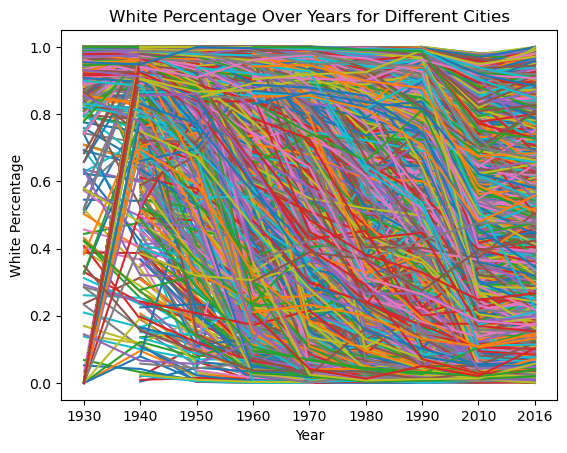

In [52]:
### Plotting white percentage for all rows in holc_data
years = ['1930','1940','1950','1960','1970','1980','1990','2010', '2016']
df = holc_data

rows, columns = df.shape

for i in range(rows):

  city_data = df.iloc[i]
  city_income = [city_data[f'white_perc_{year}'] for year in years]

  plt.plot(years, city_income, label=city_data.city)

plt.xlabel('Year')
plt.ylabel('White Percentage')
plt.title('White Percentage Over Years for Different Cities')
#plt.legend()
plt.show()

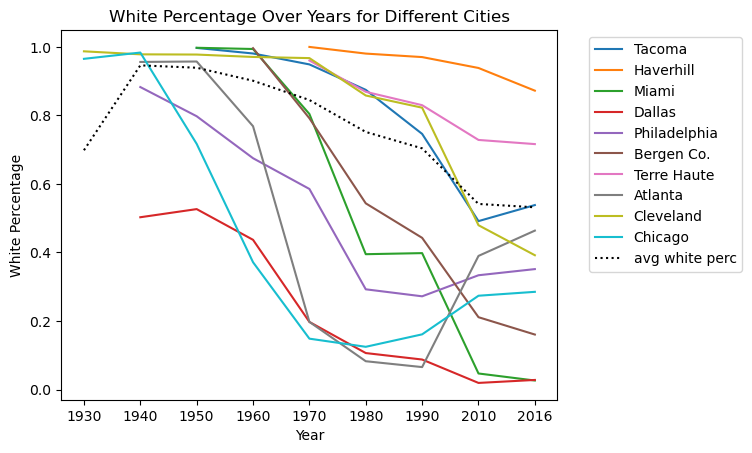

In [81]:
##this is way too dense, so I randomly sample 10 places to plot
#I also plot the avg values so there's a sense of all data

metric_name = "white_perc_"
sampled_rows = df.sample(n=10)
for index, row in sampled_rows.iterrows():
  city_white_perc = [row[f'{metric_name}{year}'] for year in years]

  plt.plot(years, city_white_perc, label=row.city)

#also plot mean
avg_vals = [df[f'{metric_name}{year}'].mean() for year in years]
plt.plot(years, avg_vals, linestyle=':', color='black', label="avg white perc")

plt.xlabel('Year')
plt.ylabel('White Percentage')
plt.title('White Percentage Over Years for Different Cities')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

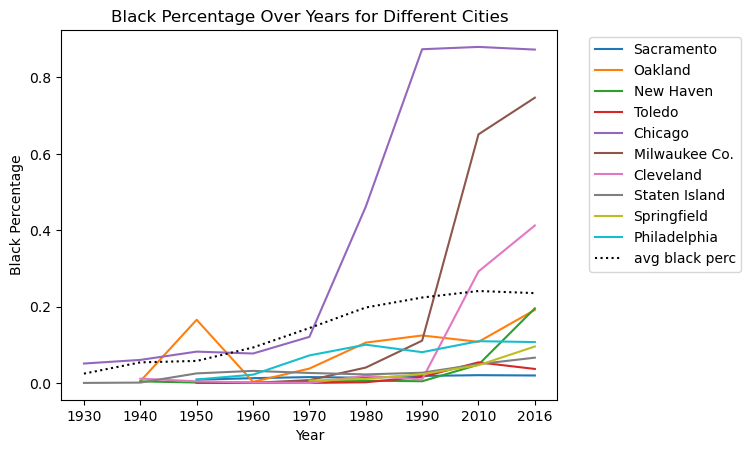

In [87]:
##black percentage
metric_name = "black_perc_"
sampled_rows = df.sample(n=10)
for index, row in sampled_rows.iterrows():
  city_white_perc = [row[f'{metric_name}{year}'] for year in years]

  plt.plot(years, city_white_perc, label=row.city)

#also plot mean
avg_vals = [df[f'{metric_name}{year}'].mean() for year in years]
plt.plot(years, avg_vals, linestyle=':', color='black', label="avg black perc")

plt.xlabel('Year')
plt.ylabel('Black Percentage')
plt.title('Black Percentage Over Years for Different Cities')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

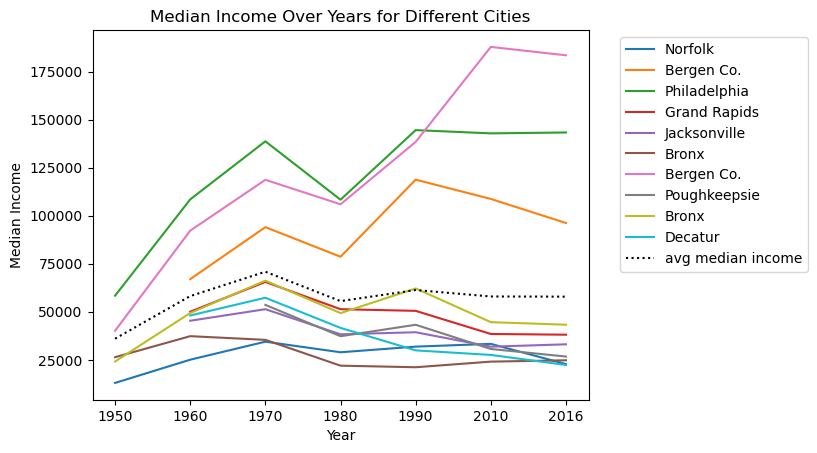

In [84]:
#there's no income data for 1930/40, so shortening year list
short_years = ['1950','1960','1970','1980','1990','2010', '2016']

metric_name = "median_inc_"

##this is way too dense, so I randomly sample 10 places to plot
sampled_rows = df.sample(n=10)
for index, row in sampled_rows.iterrows():
  city_income = [row[f'{metric_name}{year}'] for year in short_years]

  plt.plot(short_years, city_income, label=row.city)

#also plot mean
avg_vals = [df[f'{metric_name}{year}'].mean() for year in short_years]
plt.plot(short_years, avg_vals, linestyle=':', color='black', label="avg median income")

plt.xlabel('Year')
plt.ylabel('Median Income')
plt.title('Median Income Over Years for Different Cities')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
### insert your code here


## 1.3 Predicting HOLC grade using socioeconomic and demographic data during redlining (10 pts)
We believe that since HOLC grades are determinative of demographic and socioeconomic characteristics, we can back out grades by using some of these characteristics. Let's use some of these to predict HOLC grades. Here you will use the `holc_data` dataset. 

First, create `X` and `y` arrays contains our features and targets. 

In [107]:
## insert your code here.
#here's all the data columns we are interested in
data_cols = ['population_2016', 'white_perc_2016',
       'black_perc_2016', 'hispanic_perc_2016', 'other_perc_2016',
       'college_perc_2016', 'median_inc_2016', 'unemployed_perc_2016',
       'population_1930', 'white_perc_1930', 'black_perc_1930',
       'population_1940', 'white_perc_1940', 'black_perc_1940',
       'population_1950', 'white_perc_1950', 'black_perc_1950',
       'other_perc_1950', 'college_perc_1950', 'median_inc_1950',
       'population_1960', 'white_perc_1960', 'hispanic_perc_1960',
       'black_perc_1960', 'other_perc_1960', 'college_perc_1960',
       'median_inc_1960', 'population_1970', 'white_perc_1970',
       'hispanic_perc_1970', 'black_perc_1970', 'other_perc_1970',
       'college_perc_1970', 'median_inc_1970', 'population_1980',
       'white_perc_1980', 'black_perc_1980', 'hispanic_perc_1980',
       'other_perc_1980', 'college_perc_1980', 'median_inc_1980',
       'unemployed_perc_1980', 'population_1990', 'white_perc_1990',
       'black_perc_1990', 'hispanic_perc_1990', 'other_perc_1990',
       'college_perc_1990', 'median_inc_1990', 'unemployed_perc_1990',
       'population_2000', 'white_perc_2000', 'black_perc_2000',
       'hispanic_perc_2000', 'other_perc_2000', 'college_perc_2000',
       'median_inc_2000', 'unemployed_perc_2000', 'population_2010',
       'white_perc_2010', 'black_perc_2010', 'hispanic_perc_2010',
       'other_perc_2010', 'college_perc_2010', 'median_inc_2010',
       'unemployed_perc_2010']

X = holc_data[data_cols]
y = holc_data['holc_grade']

Do we have any `NaN`s? Our ML models will not accept missing data. 

In [111]:
##yes, there are NaNs in the X values (not in the Y values) 
print(f"total NaNs in X: {X.isna().sum().sum()}")
print(f"total NaNs in y: {y.isna().sum()}")

total NaNs in X: 54764
total NaNs in y: 0


In order to assure we do not have any `NaNs` in our data, which , we'll replace all of our `NaN`s with the median of the column

In [112]:
## insert your code here. 
X =X.fillna(X.mean())

We'll also want standardize our data as well.

In [ ]:
## insert your code here. 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_standardized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

Now let's split our data into a train and test set. 

In [116]:
## insert your code here. 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_standardized, y, test_size=0.33)

Using a `RandomForestClassifier` model, let's train our model to predict `y_train` on the input data `X_train` 

In [120]:
## insert your code here. 
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)

How well did our model do? Show the accuracy, F1, AUC ROC, log loss

In [121]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')  # Assuming multi-class classification
auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')  # One-vs-Rest (OvR) strategy for multi-class AUC-ROC
logloss = log_loss(y_test, y_pred_proba)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("AUC-ROC Score:", auc_roc)
print("Log Loss:", logloss)

print("the performance was not so great.")

Accuracy: 0.5470949115842656
F1 Score: 0.5225170304238048
AUC-ROC Score: 0.8098687907804651
Log Loss: 0.9950420911757104


In [ ]:
## insert your code here


Now try a different model and let's see if our results were better. 

In [ ]:
## insert your code here.


Show the classification scores again for this new model. 

In [ ]:
## insert your code here.


Since the scores weren't so different, let's go back to the RF Classifier model and tune its hyperparamters, so we can look at feature importances later. Please explain what you chose to tune. 

In [ ]:
## insert your code here.


Now, how well did you prediction improve? 

In [ ]:
### insert your code here


## 1.4 Feature importances (3pts)
Create a plot of the feature importances for each feature. You can use the sample code here: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

- What seems to be most important features in determining outcomes? 
- Is this surprising? What did you expect to be more important? 

In [ ]:
## insert your code here.   


## 1.5 Predicting with pre-redlining data (10 pts)
We're going to use the 1930s data and the change between 1930 and 1940, since we don't really have a lot of data for 1930.

- How did the scores change? 
- What were the most important features and is this surprising? 

First, create the `population_1940_1930_diff`, `black_perc_1940_1930_diff`, `white_perc_1940_1930_diff` variables that show the change in these three between 1930 and 1940. 

In [ ]:
## insert your code here.


Now run a classification model again. 

In [ ]:
## insert your code here.


And show how well the model did and whether the scores changed. 

In [ ]:
## insert your code here.


And what are the feature importances? 

In [ ]:
## insert your code here.


## Bonus: Feature creation (5 pts)
Let's say we think that the distance to the center of the city matters in terms of what the grade might be. 
- Create a new column called `dist_center` that is the distance from the centroid of each neighborhood (row) to the centroid of all the rows for each `city`. 
- Include this new column in your model. 
- Did it improve your scores? 



In [ ]:
## insert your code here.


# 2. Predicting NYC taxi pick-up and drop-offs (40 pts)
In this exercise, we will be trying to predict where a taxi is being picked up based on where it's dropped off. 

That is: we want to predict the `PULocationID` using the rest of the data. 

This data is from: 
https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

- Please familiarize yourself with the data dictionary and the taxi zones. 
- Would it make sense to add more features by bringing in more data through, for ex, the census? 

In [ ]:
### You will have to download the data from the link above
### A parquet file is a file format that is very efficient for
### storing dataframes. 

taxi_data = pd.read_parquet('yellow_tripdata_2024-01.parquet')

In [ ]:
## insert code here